#                                           ¡Bienvenidos! 
## El siguiente codigo es el resultado en un arduo trabajo del equipo de modelos. Esperemos les guste. Si no, aquí hay un video de gatos. Ellos nunca desilucionan: 
##                   https://www.youtube.com/watch?v=tntOCGkgt98

# Welcome! 

## The following code is the result of a hell of a lot of work by a couple of enthusiastic nerds. We hope you like it. If you don't, here's a video of some cats. That should make your day:

## https://www.youtube.com/watch?v=tntOCGkgt98

In [12]:
#importamos todas las vainas pertinentes
#We import the pertinent functions. 

%pylab inline
import timeit

Populating the interactive namespace from numpy and matplotlib


In [13]:
#We declare all the variables that will be used in the code for E.coli
#Declaramos todas las variables que seran utilizadas en el codigo para E.coli

aL = 20.0     #Producción basal de EAi
bL = 400.0     #Maxima rata de expresión de pLac ---->varia entre 100 y 400
kL = 3000.0   #La mitad de la rata de expresión máxima de pLac
nL = 2.0      #Coeficiente de Hill de pLac
gEAi = 0.033  #Constante de degradación de EAi
aPr = 20.0    #Producción basal de MER
bPr = 580.0   #Maxima rata de expresión de pR #caculado a partir de real
kPr = 5800.0  #La mitad del valor máximo de expresión de pR # real 
nPr = 2.0     #Coeficiente de hill de pR
gMER = 0.033  #Constante de degradación de MER
bHg = 0.005  #Coeficiente de acople de mercurio a MER #Del estocástico
bHgMER = 0.00001406334639 #Coeficiente de acople de HgMER a MER, para crear el dímero HgMER2 #estimado por orden de magnitud
dHgMER2 =60/(51*15)  #Coeficiente de desacoplamiento del dímero HgMER2 #REAL 
dHgMER = 60/(47*15)      #Coeficiente de desacoplamiento del compuesto HgMER
gHgMER = 0.033  #Constante de degradación de HgMER
gHgMER2 = 1/51  #Constante de degradación de HgMER2 --------------
aPt = 20.0    #Produccion basal del promotor pt
bPt = 580.0   #Maxima rata de expresión de pT
kPt = 5800.0  #La mitad de la rata de expresión máxima de pT
nPt = 2.0     #Coeficiente de Hill de pT
gLI = 0.0231   #Constante de degradación de LI
gXI = 0.033   #Constante de degradación de XI 



#We define a pair of arrays that will let us calculate the time it will take the simulation to run based on the 
#time we wan the system to evolve for. 

#Definimos un par de arrays que nos dejaran aproximar el tiempo que le tomara a la simulacion correr basado en el 
#tiempo por el cual queremos que el sistema evolucione. 
tdemora=[]
tcorrer=[]


In [14]:
#Definimos la función de señal, que regula Hg
#We define the signal function
def signal(t):
    return 50000*e**(-(t-70)**2/2*100) #Gaussian signal centered at 15mins, sigma=10.
    #return 50000*sin(2*3.141592*t/30)+50000 #Seno de periodo de media hora. (Sine with a period of half an hour)
    #return 4000*sin(2*3.141592*t/1440)+4000 #Seno de periodo de un día. (Sine with a perdiod of a day)
#     return 0
    
    
    
#Definimos la función paso, esta actualiza el valor de cada uno de los compuestos. Tiene como entrada el tiempo actual
#y la cantidad de todos los compuestos antes del paso. Retorna el tiempo y la cantidad de todos los compuestos despues del paso.
#We define the step function, it refreshes the value of each one of the compounds. Has as input the values of the time and
#the concentration of each compound previous to the step. Returns the time and amount of all of the compounds involved after the step.
def st(t_old, EAi_old, MER_old, HgMER_old, HgMER2_old, LI_old, XI_old, Hg_old):
    
    EAi = EAi_old
    MER = MER_old
    HgMER = HgMER_old
    HgMER2 = HgMER2_old
    LI = LI_old
    XI = XI_old
    Hg = Hg_old
    
    #Se crean arreglos para calcular la probabilidad de cada evento, uno de ellos es acumulativo.
    #Two arrays are initialized to calculate the probability of each event, one of them is a cumulative one.
    
    ks=[]        #Constantes de probabilidad (probability constants)
    cltive=[]    #Constantes acumulativas (cumulative probabilities)
    
    #Aquí mostraremos la ecuación maestra de todos los compuestos. Cada ecuación se refiere al proceso de un compuesto,
    #cada término de cada ecuación se refiere a un proceso en donde el compuesto en cuestión se encuentra involucrado.
    #Here will show the master equations of all of the compounds. Every equation refers to the process of a compound, 
    #each term in each equation refers to a process where the compound in context is involved.
    
    # (d/dt)EAi = aL + bL/(1+(LI/kL)**nL) - gEAi*EAi
    
    k0 = aL                   #Produccion constitutiva de EAi                          EAi+= 60
    k1 = bL/(1+(LI/kL)**nL)   #Termino de represion de la producion de EAi             EAi+= 60
    k2 = gEAi*EAi             #Degradacion de EAi                                      EAi+= -1
    ks.append(k0)
    ks.append(k1)
    ks.append(k2)
    
    # (d/dt)MER = aPr + bPr/(1+(MER/kPr)**nPr) - gMER*MER - bHg*Hg*MER - bHgMER*MER*HgMER + dHgMER2*HgMER2 + dHgMER*HgMER
    
    k3 = aPr                     #Producción constitutiva de MER                      MER+= 60
    k4 = bPr/(1+(MER/kPr)**nPr)  #Autorepresión de MER                                MER+= 60
    k5 = gMER*MER                #Degradación de MER                                  MER+= -1
    k6 = bHg*Hg*MER              #Acoplamiento de Hg y MER                           HgMER+=1, MER+= -1
    k7 = bHgMER*MER*HgMER        #Acoplamiento de MER y HgMER                        HgMER2+=1, MER+= -1, HgMER+= -1
    k8 = dHgMER2*HgMER2          #Desacoplamiento de HgMER2                          HgMER2+= -1, MER+= 1, HgMER+= 1
    k9 = dHgMER*HgMER            #Desacoplamiento de HgMER                           HgMER+= -1, MER+= 1
    
    ks.append(k3)
    ks.append(k4)
    ks.append(k5)
    ks.append(k6)
    ks.append(k7)
    ks.append(k8)
    ks.append(k9)
    
    # (d/dt)HgMER = - gHgMER*HgMER - bHg*Hg*MER - bHgMER*MER*HgMER + dHgMER2*HgMER2 + dHgMER*HgMER
    
    k10 = gHgMER*HgMER          #Degradación de HgMER                                      HgMER+= -1      
    
    ks.append(k10)
    
    # (d/dt)HgMER2 = bHgMER*MER*HgMER - dHgMER2*HgMER2 - gHgMER2*HgMER2
    
    k11 = gHgMER2*HgMER2          #Degradacion del dimero con el mercurio                   HgMER2+= -1
    ks.append(k11)
    
    
    # (d/dt)LI = aPt + bPt/(1+(kPt/HgMER2)**nPt) - gLI*LI
    
    k12 = aPt                            #Produccion constitutiva del promotor Pt            LI+= 60, XI+= 60    
    k13 = (bPt*HgMER2**nPt)/(HgMER2**nPt + kPt**nPt)      #Activacion transcripcion por HgMER2                LI+= 60, XI+= 60
    k14 = gLI*LI                         #Degradacion de LI                                  LI+= -1
    ks.append(k12)
    ks.append(k13)
    ks.append(k14)
    
    # (d/dt)XI = aPt + bPt/(1+(kPt/HgMER2)**nPt) - gXI*XI
    
    k15 = gXI*XI                          #Degradacion de XI                             XI+= -1
    ks.append(k15)
    
    #Cabe notar que para evitar un sobreconteo de eventos no todos los terminos de todas las ecuaciones son tomados en cuenta
    #In order to avoid an overcount on the events not all terms in each equation are taken into account.
    
    #Constante de normalización, suma de todas las probabilidades
    #Normalization constat, sum of all of the probabilities. 
    s = 0.0          
    for j in ks:
        s = s+j 
    
    #Creamos el arreglo de probabilidades acumulativas para poder definir cada evento.
    #We create the array of cumulative probabilities so we can define each event.
    for j in range(len(ks)):
        if(j==0):
            cltive.append(ks[0]/s)
        else:
            zzz = float(ks[j]/s)
            cltive.append(cltive[j-1] + zzz)
    
    
    #Usamos el número aleatorio r1 para generar el tiempo en el que ocurre el próximo evento de interés
    #We use the random number r1 to generate the time that the next event will take.
    r1 = random.random()
    T = (1/s)*log(1/r1) + t_old 
    
    #Generamos la señal de Hg para el sgt paso
    #We generate the signal Hg for the next step
    Hg = signal(T)    
    
    #Usamos el número aleatorio ran para generar el próximo evento de interés
    #We use the random number ran to generate the next event of interest
    ran = random.random()
    
    #Aquí decidimos cual de los posibles eventos tomará lugar
    #Here we decide which one of the events will take place
    if(ran<cltive[0]):
        EAi+= 60
            
    elif(cltive[0]<=ran<cltive[1]):
        EAi+= 60
            
    elif(cltive[1]<=ran<cltive[2] and EAi!=0):
        EAi+= -1
            
    elif(cltive[2]<=ran<cltive[3]):
        MER+= 60
            
    elif(cltive[3]<=ran<cltive[4]):
        MER+= 60
            
    elif(cltive[4]<=ran<cltive[5] and MER!=0):
        MER+= -1
            
    elif(cltive[5]<=ran<cltive[6] and MER!=0):
        HgMER+=1
        MER+= -1
            
    elif(cltive[6]<=ran<cltive[7] and MER!=0 and HgMER!=0):
        HgMER2+=1
        MER+= -1
        HgMER+= -1
    
    elif(cltive[7]<=ran<cltive[8] and HgMER2!=0):
        HgMER2+= -1
        MER+= 1
        HgMER+= 1
            
    elif(cltive[8]<=ran<cltive[9] and HgMER!=0):
        HgMER+= -1
        MER+= 1
            
    elif(cltive[9]<=ran<cltive[10] and HgMER!=0):
        HgMER+= -1
            
    elif(cltive[10]<=ran<cltive[11] and HgMER2!=0):
        HgMER2+= -1
            
    elif(cltive[11]<=ran<cltive[12]):
        LI+= 60
        XI+= 60
            
    elif(cltive[12]<=ran<cltive[13]):
        LI+= 60
        XI+= 60
            
    elif(cltive[13]<=ran<cltive[14] and LI!=0):
        LI+= -1
    
    elif(cltive[14]<=ran<=cltive[15] and XI!=0):
        XI+= -1
        
    
    #Por último, retornamos los valores actualizados
    #At last, we return the new values
    
    return T, EAi, MER, HgMER, HgMER2, LI, XI, Hg



#Definimos la funcion Cell (célula), tiene como input el tiempo EN HORAS en el que quieres correr el sistema, la ventana
#de tiempo para estandarizar los arreglos (dt: algo entre 0.3 y 0.5 sirve), y la concentración inicial de cada uno de
#los compuestos del sistema.
#Retorna todos los arreglos de concentraciones (estandarizados y regulares)
#We define the Cell function, its input is the time you want to run the system IN HOURS, the window of time used to
#standardize the arrays (dt: something between 0.3 and 0.5 should do it), and the initial concentration 
#of each of the components of the system.
#Returns all the arrays of the concentrations (standardized and regular ones)
def cell(hours, dt, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0):
    
    #Definimos los arreglos del tiempo y los compuestos como vacios
    #We define the arrays of time and compounds as empty
    T = []
    EAi = []
    MER = []
    HgMER = []
    HgMER2 = []
    LI = []
    XI = []
    Hg = []    
    
    #Agregamos los valores iniciales de cada uno de los compuestos a los arreglos
    #We append the initial values to their corresponding arrays
    t = 0.0
    
    T.append(0.0)
    EAi.append(EAi_0)
    MER.append(MER_0)
    HgMER.append(HgMER_0)
    HgMER2.append(HgMER2_0)
    LI.append(LI_0)
    XI.append(XI_0)
    Hg.append(Hg_0)
    
    #Simulamos la celula usando la función step (st)
    #Let's run it!! (using the step function: st)
    while t < hours*60.0:
        
        #Seguimos usando los mismos nombres para las variables, excepto que ya no serán los valores iniciales.
        #We keep the same names for the variables, except they wont be the initial ones anymore.
        t, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0 = st(t, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0)
        #Guardamos los valores generados
        #We save the generated values
        T.append(t)
        EAi.append(EAi_0)
        MER.append(MER_0)
        HgMER.append(HgMER_0)
        HgMER2.append(HgMER2_0)
        LI.append(LI_0)
        XI.append(XI_0)
        Hg.append(Hg_0)
        
    #Para hacer el promedio entre muchas células tenemos que estandarizar el tiempo
    #Aquí es donde usamos dt para calcular cuantos intervalos se quieren
    #To average between many cells we have to standardize the time
    #Here is where we use dt to calculate how many intervals are wanted
    T_s = linspace(0, hours*60.0, int(hours*60.0/dt))
    
    #Inicializamos los arreglos estandarizados
    #We initialize the standardize arrays
    EAi_s = zeros(len(T_s))
    MER_s = zeros(len(T_s))
    HgMER_s = zeros(len(T_s))
    HgMER2_s = zeros(len(T_s))
    LI_s = zeros(len(T_s))
    XI_s = zeros(len(T_s))
    Hg_s = zeros(len(T_s))
    
    #Aquí estandarizamos para que se pueda hacer un promedio
    #Here we standardize so an average can be made
    for i in range(len(T_s)):
        j = 0
        while(T[j] < T_s[i]):
            j+=1
            
        EAi_s[i] = EAi[j]
        MER_s[i] = MER[j]
        HgMER_s[i] = HgMER[j]
        HgMER2_s[i] = HgMER2[j]
        LI_s[i] = LI[j]
        XI_s[i] = XI[j]
        Hg_s[i] = Hg[j]
    
    #Finalmente retornamos los arreglos, primero los estandarizados.
    #Finally the arrays are returned, the standardized ones first.
    
    return T_s, EAi_s, MER_s, HgMER_s, HgMER2_s, LI_s, XI_s, Hg_s, T, EAi, MER, HgMER, HgMER2, LI, XI, Hg



#Definimos la función "Muchas celulas"(sv_cells), tiene como input el numero de sistemas que quieres simular, el tiempo
#que quieres correr el sistema EN HORAS, la ventana de tiempo para estandarizar los arreglos (dt: algo entre 0.3 y 0.5 
#funciona), y el valor inicial de la concentración de cada compuesto del sistema.
#Retorna todos los arreglos de concentraciones
#We define the Several Cells function, its input is the number of systems you wanto simulate, the time you want to run 
#the system IN HOURS, the window of time used to standardize the arrays (dt: something between 0.3 and 0.5 should do it), 
#and the initial concentration of each of the components of the system.
#Returns all the arrays of the concentrations
def sv_cells(N_cells, hours, dt, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0):
    
    #Definimos la contidad de puntos en el eje temporal
    #We define the amount of points in the temporal axis
    n_points = int(hours*60.0/dt)
    #Definimos una matriz para cada uno de los componentes del sistema
    #We define a matrix for each of the components of the system
    EAi = zeros((N_cells, n_points))
    MER = zeros((N_cells, n_points))
    HgMER = zeros((N_cells, n_points))
    HgMER2 = zeros((N_cells, n_points))
    LI = zeros((N_cells, n_points))
    XI = zeros((N_cells, n_points))
    Hg = zeros((N_cells, n_points))
    
    #Ahora llenamos las matrices, corriendo N_cells veces
    #Now we fill the matrices, running N_cells times
    for i in range(N_cells):
        
        #Nombramos los resultados y extraemos los arreglos estandarizados
        #We name the results and extract the standardized arrays
        stuff = cell(hours, dt, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0)
        
        T_s = stuff[0]
        EAi[i,:] = stuff[1]
        MER[i,:] = stuff[2]
        HgMER[i,:] = stuff[3]
        HgMER2[i,:] = stuff[4]
        LI[i,:] = stuff[5]
        XI[i,:] = stuff[6]
        Hg[i,:] = stuff[7]
    
    #Iniciamos los arreglos de los promedios
    #We initialize the average arrays
    ave_EAi = zeros( n_points)
    ave_MER = zeros( n_points)
    ave_HgMER = zeros( n_points)
    ave_HgMER2 = zeros( n_points)
    ave_LI = zeros( n_points)
    ave_XI = zeros( n_points)
    ave_Hg = zeros( n_points)
    
    #Llenamos los arreglos de los promedios respectivos para cada punto temporal
    #We fill the arrays with the respective averages for each temporal point
    for k in range(n_points):
        ave_EAi[k] = average(EAi[:,k])
        ave_MER[k] = average(MER[:,k])
        ave_HgMER[k] = average(HgMER[:,k])
        ave_HgMER2[k] = average(HgMER2[:,k])
        ave_LI[k] = average(LI[:,k])
        ave_XI[k] = average(XI[:,k])
        ave_Hg[k] = average(Hg[:,k])
    
    #Finalmente retornamos los arreglos recién horneados :3
    #Finally we return the freshly baked arrays :3
    return T_s, ave_EAi, ave_MER, ave_HgMER, ave_HgMER2, ave_LI, ave_XI, ave_Hg

#Reimos :D
#Now we laugh
print("lol")
    
    
    

lol


# Prueba para una célula (One cell test)

In [15]:
#Cuanto tiempo queremos correr el programa
#How much time we want to run the program

hours = 7

#We record the time in seconds at which we started the code in the variable timer1. 
#Guardamos el tiempo (en segundos) en el que comenzamos a correr el codigo en la variable timer1.  
timer1 = timeit.default_timer()




#Ventana de tiempo entre pasos
#Window of time between steps
dt = 0.5
#Valores iniciales
#Initial values
# EAi_0 = 44436
# MER_0 = 19574
# HgMER_0 = 17469
# HgMER2_0 = 24197
# LI_0 = 156444
# XI_0 = 144247
# Hg_0 = 0

EAi_0 = 0
MER_0 = 0
HgMER_0 = 0
HgMER2_0 = 0
LI_0 = 0
XI_0 = 0
Hg_0 = 0

#Corremos el programa para una célula
#We run the program for one cell
T_s, EAi_s, MER_s, HgMER_s, HgMER2_s, LI_s, XI_s, Hg_s, T, EAi, MER, HgMER, HgMER2, LI, XI, Hg = cell(hours, dt, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0)



#We record the time at which the code ended in the variable timer2. 
#Tomamos nota del tiempo en el que termino de correr el codigo en la variable timer2. 
timer2 = timeit.default_timer()
#Agregamos el tiempo que se demoro en correr el codigo junto con el tiempo por el cual evoluciono el sistema
#en sus respectivos arrays. 
#We append the time the code took to run and the time for which the code evolved in their respective arrays. 
tcorrer.append(hours)
tdemora.append(timer2-timer1)

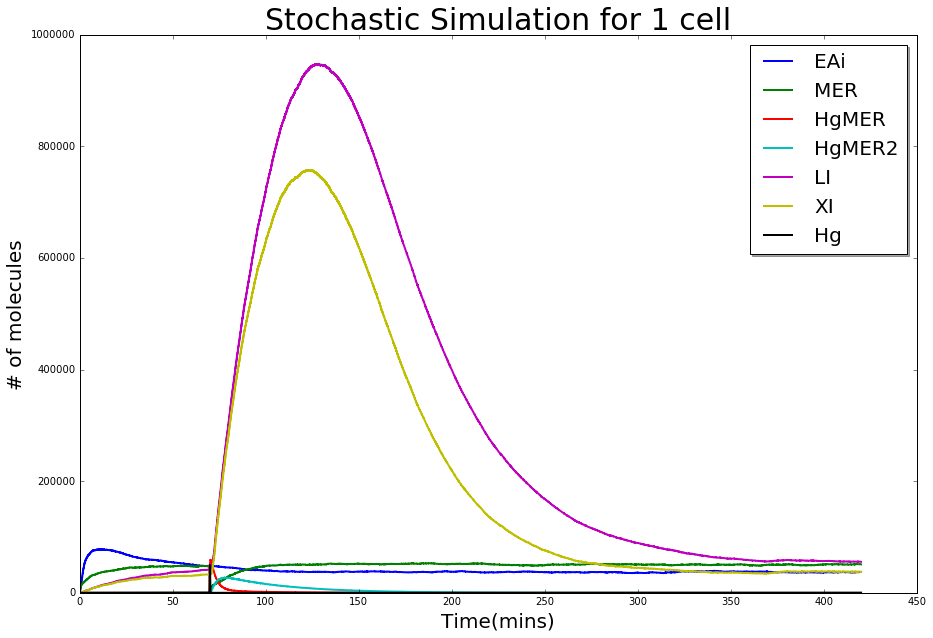

In [6]:
#Here we plot our results
#Aqui visualizamos los resultados
figure(figsize(15,10))
plot(T,EAi,label='EAi',linewidth=2)
plot(T,MER,label='MER',linewidth=2)
plot(T,HgMER,label='HgMER',linewidth=2)
plot(T,HgMER2,label='HgMER2',linewidth=2)
plot(T,LI,label='LI',linewidth=2)
plot(T,XI,label='XI',linewidth=2)
plot(T,Hg,label='Hg',linewidth=2)
plt.xlabel('Time(mins)' , fontsize = 20)
plt.ylabel('# of molecules', fontsize = 20)
plt.title('Stochastic Simulation for 1 cell', fontsize = 30)
legend1 = legend(fontsize = 20,shadow = True)
#And we save them to a file. 
#Y guardamos la imagen.
savefig('EcoliStochastic_1cell_presentacion.png')
show()

# Tiempo que se demora correr el codigo vs el tiempo por el cual evoluciona el sistema

# Time the code took to run vs time that the system evolved for

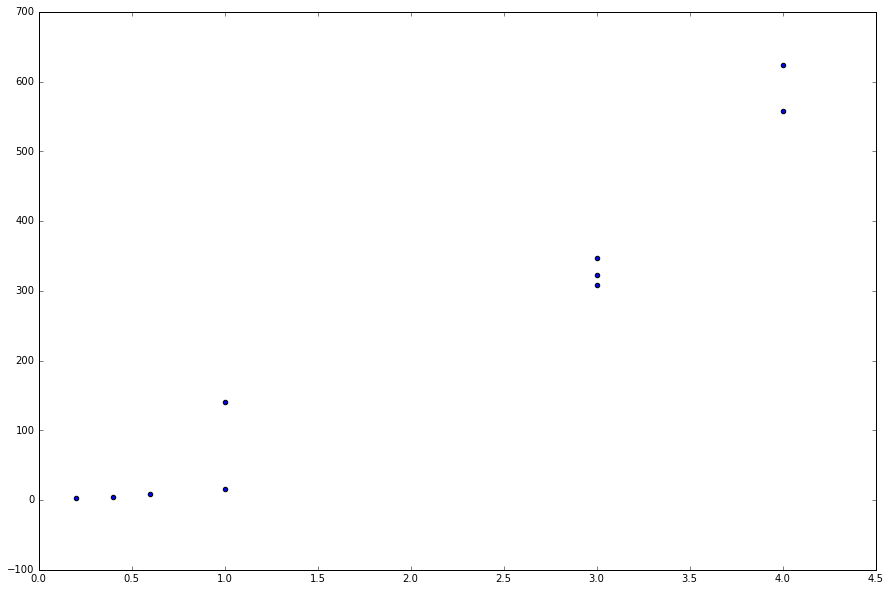

In [150]:
#We visualize the adquired data accross a lot of runs 
#Visualizamos la informacion adquirida a lo largo de muchas corridas. 
plt.scatter(tcorrer,tdemora)
xs = linspace(0,15,100)


# La prueba para muchas células, se grafica el promedio (Many cells test, we plot the average)

In [ ]:
#This part of the code was made with the intention to run it on a cluster or a computer with more computational
#power than an average laptop. Given the time constraints, we were unable to do so. Nevertheless, the code remains for 
#a future possible run or for any caring soul with a proper computer who wants to run it. 

#Esta parte del codigo fue hecha con la intencion de correrla en un cluster o una computadora con mayor poder 
#computacional que la de un laptop promedio. Dadas las restricciones de tiempo, no pudimos realizar nuestro cometido.
#Sin embargo, el codigo queda para correrlo a futuro o para cualquier alma caritativa que quiera con un computador 
#bacano que quiera correrlo. 

#El número de celulas que se quieren promedia
#The number of cells we want to average
N_cells = 5
#Cuanto tiempo queremos correr el programa
#How much time we want to run the program
hours = 1.0
#Ventana de tiempo entre pasos
#Window of time between steps
dt = 0.5
#Valores iniciales
#Initial values
EAi_0 = 0 
MER_0 = 0
HgMER_0 = 0
HgMER2_0 = 0
LI_0 = 0
XI_0 = 0
Hg_0 = 0

#Corremos el programa para N_cells células
#We run the program for N_cells
T_s, ave_EAi, ave_MER, ave_HgMER, ave_HgMER2, ave_LI, ave_XI, ave_Hg = sv_cells(N_cells, hours, dt, EAi_0, MER_0, HgMER_0, HgMER2_0, LI_0, XI_0, Hg_0)

#Reimos :D
#Now we laugh
print("lol")

#Graficamos
#We plot
figure(figsize(15,10))
plot(T_s,ave_EAi,label='EAi')
plot(T_s,ave_MER,label='MER')
plot(T_s,ave_HgMER,label='HgMER')
plot(T_s,ave_HgMER2,label='HgMER2')
plot(T_s,ave_LI,label='LI')
plot(T_s,ave_XI,label='XI')
plot(T_s,ave_Hg,label='Hg')
plt.xlabel('Time(mins)' , fontsize = 20)
plt.ylabel('# of molecules', fontsize = 20)
plt.title('Stochastic Simulation for %d cells' % (N_cells), fontsize = 30)
legend(fontsize = 10)
#savefig('EcoliStochastic_N_cells.png')
show()


# SHEWANELLA ONEIDENSIS

In [10]:
#We define a function that returns the position in the array of the standardazed time. This will be of help later on
#when we use the concentration of XI of the first bit of the code as the input for Shewanella. 

#Definimos una funcion que nos devuelva la posicion en el array del tiempo estandarizado. Esto sera muy util mas 
#adelante cuando utilicemos la concentracion de XI que obtuvimos como output en la parte previa del codigo como 
#input para Shewanella. 

def indicet(t):
    counter = 0
    while(T_s[counter]<t):
        counter +=1 
    return counter 

In [11]:
#We initialize the time array t2, the arrays for proteins and establish
#the constants that will be used in the equations. 

#Inicializamos el array de tiempo de esta corrida, t2, los arrays de las proteinas y establecemos las 
#constantes que utilizaremos en las ecuaciones. 

t2  = [0.0]
Tau=0
XR = [0.0]
XR2 = [0.0]
CY =[0.0]
A = [0.0]

kr1 = 0.000001406 #Constante de acople de XR y AHL. 
aXR=90.000   #important, adjusted value 
bXR=300.000 #No va 
kXR=3000.000 #typical value 
gXR=0.060 #real, checked 
dXR2=0.1998 #real, important not checked 
aX=0.004691138 #real, basal checked, important
bX=300.000 #typical value 
kc=0.000001406334639 #real, important 
nX=1.000 #Assumed ...why?
kX=50000.148 #not important 
gCY=0.00071666667+0.1 #important checked, strange value  
kXR2=3000.000 #esto no va 
gXR2=0.0231 #not important not checked



In [12]:
#We define a funtion that will determine the event that will occur after the time of interest is calculated.
#This is calculated according to a random number. Although it makes more sense (at least cronologically), to 
#declare this if statement after we define the events, computationally, it is favourable for us to define this function
#beforehand. 

#Definimos una funcion que determinara el evento que va a ocurrir despues que se calcule el tiempo necesario 
#para que ocurra algo interesante. Esto se calcula a partir de un numero alteatorio. Aunque tiene mas sentido
#(por lo menos cronologicamente) declarar este if despues de que se definan los eventos, computacionalmente, es 
#favorable definir esta funcion con anterioridad. 


def decider(random):
        if(0<=random<cltive[0]):
            XR.append(XR[i] + 60) 
            XR2.append(XR2[i])
            CY.append(CY[i])
            A.append(XI_s[indicet(Tau)])
        elif(cltive[0]<=random<cltive[1] and XR[i] != 0):
            XR.append(XR[i] -1 )    
            XR2.append(XR2[i] + 1)
            CY.append(CY[i])
            A.append(XI_s[indicet(Tau)])
        elif(cltive[1]<=random<cltive[2] and XR[i] != 0):
            XR.append(XR[i] - 1)    
            XR2.append(XR2[i])
            CY.append(CY[i])
            A.append(XI_s[indicet(Tau)])
        elif(cltive[2]<=random<cltive[3] and XR2[i] !=0):
            XR.append(XR[i] +1)   
            XR2.append(XR2[i] -1)
            CY.append(CY[i])
            A.append(XI_s[indicet(Tau)])
        elif(cltive[3]<=random<cltive[4] and XR2[i] !=0):
            XR.append(XR[i])    
            XR2.append(XR2[i] -1) 
            CY.append(CY[i])
            A.append(XI_s[indicet(Tau)])
        elif(cltive[4]<=random<cltive[5]):
            XR.append(XR[i])    
            XR2.append(XR2[i])
            CY.append(CY[i] + 60)
            A.append(XI_s[indicet(Tau)])
        elif(cltive[5]<=random<cltive[6]):
            XR.append(XR[i])    
            XR2.append(XR2[i]) 
            CY.append(CY[i] +60)
            A.append(XI_s[indicet(Tau)])
        elif(cltive[6]<=random<cltive[7] and CY[i] != 0):
            XR.append(XR[i])    
            XR2.append(XR2[i])
            CY.append(CY[i] - 1) 
            A.append(XI_s[indicet(Tau)])
        else:
            XR.append(XR[i])    
            XR2.append(XR2[i])
            CY.append(CY[i]) 
            A.append(XI_s[indicet(Tau)])

In [13]:
# This is the meaty part of the code. This is where the magic happens. We make the code iterate itself as long
#as the time that has gone by is less than the time in simulation we want the code to run for. In this case, that is 
#419 minutes. After that, our code will break out of the for loop. The reason we want the code to run for 
# 60000000000000 iterations is that we need to make sure the ammount of iterations surpases the time we want the 
#simulation to run for. 

#Esta es la parte iteresante de codigo. Aqui es donde se baila la cumbia. Hacemos que el codigo itere siempre y cuando
#el tiempo que haya pasado sea menor al tiemp que queremos que corra la simulacion. En este caso, eso es 419 minutos. 
#Hacemos que el codigo corra por 60000000000000 iteraciones para asegurarnos que las iteraciones sobrepasen el tiempo
#que queremos que el tiempo de la simulacion corra. 

for i in range(60000000000000):
    if(Tau<419):
        ks=[]
        cltive=[]

        #XR events

        k0 = aXR
        k1 = kr1*XR[i]*A[i]
        k2 = gXR*XR[i]
        k3 = dXR2*XR2[i]
        ks.append(k0)
        ks.append(k1)
        ks.append(k2)
        ks.append(k3)

        #XR2 events


        k4 = gXR2*XR2[i] 
        ks.append(k4)


        #CY events

        k5 = aX
        k6 = (bX*pow(XR2[i],nX))/(pow(kX, nX) + pow(XR2[i],nX))
        k7 = gCY*CY[i]
        ks.append(k5)
        ks.append(k6)
        ks.append(k7)

        #s will represent the sum of all events

        s = 0

        for j in ks:
            s = s+j 

        for j in range(len(ks)):
            if(j==0):
                cltive.append(ks[0]/s)
            else:
                cltive.append(cltive[j-1] + ks[j]/s)

        r1 = random.random()

        #We calculate the time interval for the next event to happen

        Tau = (1/s)*log(1/r1) + t2[i]

        #The time interval is added to the time array

        t2.append(Tau)

        #This random number will decide which event is chosen.

        r2 = random.random()



        #This recalls the function to decide which event happens. 
        decider(r2)
    else:
        break

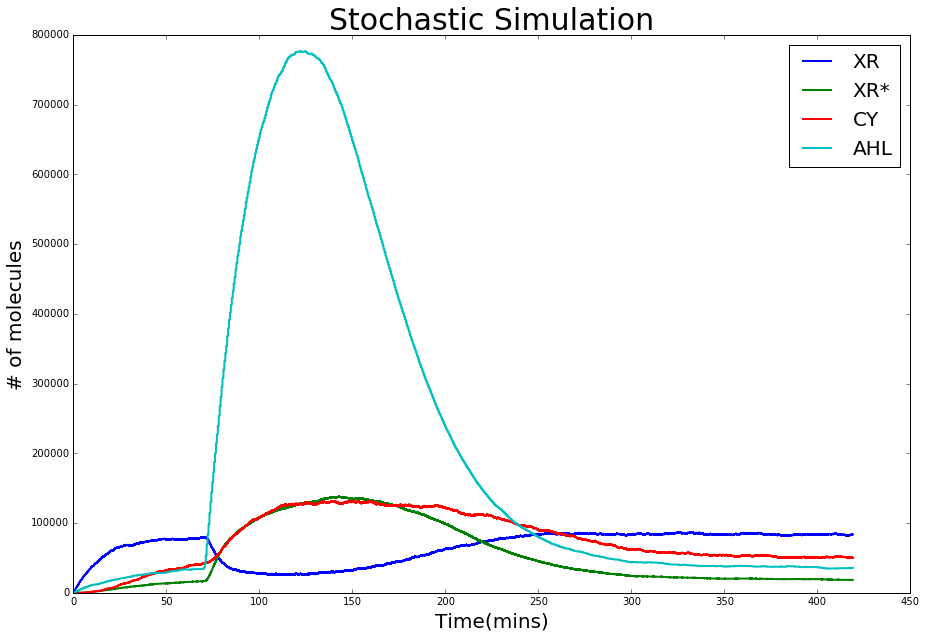

In [ ]:
#We visualize the data and sava the image as a photo. 

#Graficamos los resultados y guardamos los resultados en una foto. 

figure(figsize(15,10))
plot(t2,XR,label='XR',linewidth = 2)
plot(t2,XR2,label='XR*',linewidth = 2)
plot(t2,CY,label='CY',linewidth = 2)
plot(t2,A,label='AHL',linewidth = 2)
plt.xlabel('Time(mins)' , fontsize = 20)
plt.ylabel('# of molecules', fontsize = 20)
plt.title('Stochastic Simulation', fontsize = 30)
legend(fontsize = 20)
savefig('shewiepresentacion.png')
show()